In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist
from skbio import TreeNode
from skbio.stats.ordination import pcoa
import seaborn as sns
import skbio.diversity
from scipy.special import gammaln
from skbio import DistanceMatrix
from sklearn.manifold import MDS
%matplotlib inline

In [2]:
# Load OTU table
otu_table_df = pd.read_csv("../results_COI/01-run/AllSamples_97clust90assign/AllSamples_otu_table.txt", sep='\t', index_col=0).sort_index()

# Load taxonomy table
tax_table_df = pd.read_csv("../results_COI/01-run/AllSamples_97clust90assign/output/plot_AllSamples_tax_assignments.txt", sep='\t', index_col=0).sort_index()

# Load metadata
meta_table_df = pd.read_csv("../test_data/mapping_file_COI.csv", sep=',', index_col=0).sort_index()

In [3]:
otu_table_df

,SRR15685627,SRR15685628,SRR15685672,SRR15685673,SRR15685674,SRR15685675,SRR15685676
OTUId,,,,,,,
OTU101804100,0,0,21,0,0,0,0
OTU106785004,0,0,0,0,37,20,0
OTU11393800,0,0,0,0,0,0,24
OTU115398801,0,0,0,0,0,0,63
OTU1163968,0,0,0,0,34,0,0
...,...,...,...,...,...,...,...
OTU979402011,0,0,1033,0,0,0,0
OTU981093779,0,0,0,0,0,49,0
OTU986576230,0,0,191,0,0,0,47


In [4]:
tax_table_df

,kingdom,phylum,class,order,family,genus,species,similarity
otu_id,,,,,,,,
OTU101804100,Unassigned,Unassigned,Unassigned,Unassigned,Unassigned,Unassigned,Unassigned,1.00000
OTU106785004,Unassigned,Unassigned,Unassigned,Unassigned,Unassigned,Unassigned,Unassigned,1.00000
OTU11393800,Animalia,Arthropoda,Insecta,Hymenoptera,Tenthredinidae,Cladius,compressicornis,0.91457
OTU115398801,Unassigned,Unassigned,Unassigned,Unassigned,Unassigned,Unassigned,Unassigned,1.00000
OTU1163968,Animalia,Arthropoda,Insecta,Coleoptera,Curculionidae,Hylesinus,fraxini,0.93000
...,...,...,...,...,...,...,...,...
OTU979402011,Animalia,Arthropoda,Insecta,Lepidoptera,Nymphalidae,Eresia,ithomioides,0.93970
OTU981093779,Animalia,Arthropoda,Insecta,Hemiptera,Cercopidae,Deois,sp. AP-2016,0.90050
OTU986576230,Animalia,Arthropoda,Insecta,Coleoptera,Scarabaeidae,Xylotrupes,pubescens,0.91146


In [5]:
meta_table_df

,SampleName,Species
SampleID,,
SRR15685627,SRR15685627,Nyctinomops_laticaudatus
SRR15685628,SRR15685628,Nyctinomops_laticaudatus
SRR15685672,SRR15685672,Histiotus_diaphanopterus
SRR15685673,SRR15685673,Histiotus_diaphanopterus
SRR15685674,SRR15685674,Molossus_molossus
SRR15685675,SRR15685675,Molossus_molossus
SRR15685676,SRR15685676,Peropteryx_sp.


In [6]:
# Create the 'plots' directory if it doesn't exist
output_dir = 'plots'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

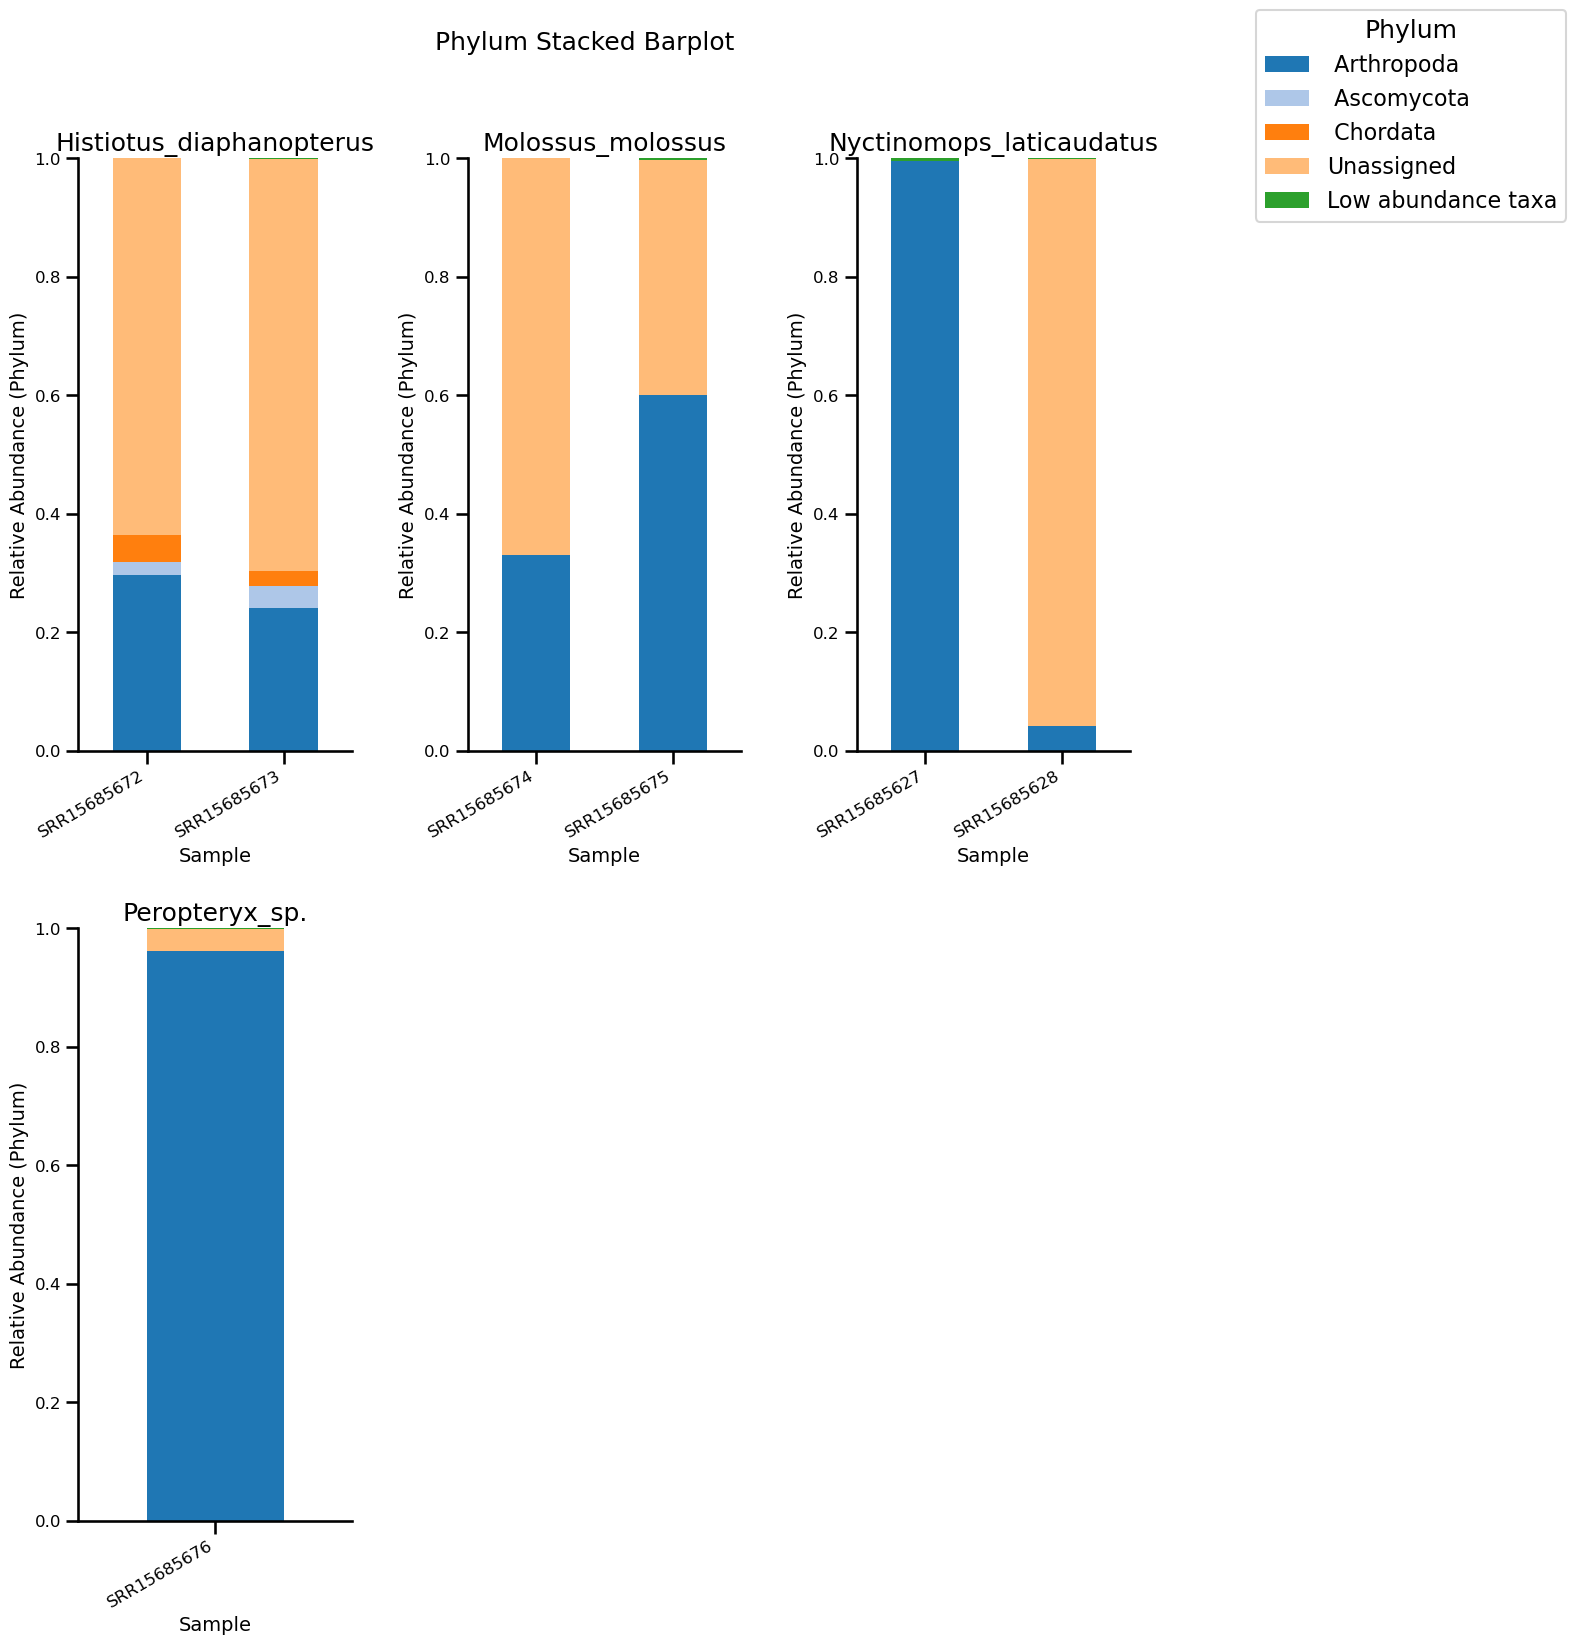

In [7]:
def plot_taxonomic_composition(otu_table_df, tax_table_df, meta_table_df, rank, output_dir, groupby):
    # Copy and transform the OTU table
    ps_taxa = otu_table_df.copy()
    ps_taxa[rank] = tax_table_df[rank]
    ps_taxa = ps_taxa.groupby(rank).sum()
    ps_taxa = ps_taxa / ps_taxa.sum()  # Transform to relative abundance
    ps_taxa = ps_taxa.reset_index()
    ps_taxa = pd.melt(ps_taxa, id_vars=rank, var_name='Sample', value_name='Abundance')
    ps_taxa = ps_taxa[ps_taxa['Abundance'] > 0.01]  # Filter out low abundance taxa
    ps_taxa = ps_taxa.sort_values(by=rank)  # Sort data frame alphabetically by the taxonomic rank
    
    # Merge metadata into the transformed OTU table
    ps_taxa = ps_taxa.merge(meta_table_df, left_on='Sample', right_index=True, how='left')
    
    # Define the number of unique taxa and generate the color palette
    n = len(ps_taxa[rank].unique()) + 1
    palette = sns.color_palette("tab20", n)
    
    # Set plot size and font scale
    sns.set_context("talk", font_scale=1.2)
    
    # Plotting with seaborn FacetGrid for faceting
    if groupby:
        # Pivot the dataframe to get the format needed for stacked bars
        pivot_df = ps_taxa.pivot_table(index=['Sample', groupby], columns=rank, values='Abundance').fillna(0).reset_index()
        
        # Calculate low abundance taxa per sample and add to pivot_df
        pivot_df['Low abundance taxa'] = 1 - pivot_df.drop(columns=['Sample', groupby]).sum(axis=1)
        
        # Save pivot_df to a CSV file
        pivot_df.to_csv(os.path.join(output_dir, f'{rank}_pivot_table.tsv'), sep='\t')
        
        # Initialize the FacetGrid
        g = sns.FacetGrid(pivot_df, col=groupby, col_wrap=3, sharey=False, sharex=False, height=8, aspect=0.5)
        
        # Plot the stacked bar plot within each facet
        for ax, (name, df) in zip(g.axes.flat, pivot_df.groupby(groupby)):
            df.set_index('Sample').drop(columns=[groupby]).plot(kind='bar', stacked=True, color=palette, ax=ax, legend=False)
            ax.set_title(name, fontsize=18)
            ax.set_xlabel("Sample", fontsize=14)
            ax.set_ylabel(f"Relative Abundance ({rank.capitalize()})", fontsize=14)
            ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right', fontsize=12)
            ax.set_yticks(ax.get_yticks())  # Ensure that ticks are set before setting labels
            ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
            ax.set_ylim(0, 1.0)  # Set the y-axis limits for each subplot

        # Manually create the legend outside the loop
        handles, labels = ax.get_legend_handles_labels()  # Get handles and labels from the last ax
        g.fig.legend(handles, labels, title=rank.capitalize(), bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='16', title_fontsize='18')
        plt.subplots_adjust(top=0.9, hspace=0.3)  # Adjust the top to make room for the title
        g.fig.suptitle(f'{rank.capitalize()} Stacked Barplot', fontsize=18)
        g.fig.savefig(os.path.join(output_dir, f'{rank}_barplots.svg'), bbox_inches='tight')
    else:
        # Pivot the dataframe to get the format needed for stacked bars
        pivot_df = ps_taxa.pivot(index='Sample', columns=rank, values='Abundance').fillna(0)
        
        # Calculate low abundance taxa per sample and add to pivot_df
        pivot_df['Low abundance taxa'] = 1 - pivot_df.sum(axis=1)
        
        # Save pivot_df to a CSV file
        pivot_df.to_csv(os.path.join(output_dir, f'{rank}_pivot_table.tsv'), sep='\t')
        
        # Plotting the stacked bar plot
        pivot_df.plot(kind='bar', stacked=True, color=palette, figsize=(20, 10))
        plt.ylabel(f'Relative Abundance ({rank.capitalize()})', fontsize=18)
        plt.xlabel('Sample', fontsize=18)
        plt.xticks(rotation=30, ha='right', fontsize=16)
        plt.yticks(fontsize=16)
        plt.legend(title=rank.capitalize(), bbox_to_anchor=(1.05, 1), loc='upper left', title_fontsize='18', fontsize='14')
        plt.title(f'{rank.capitalize()} Stacked Barplot', fontsize=22)
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f'{rank}_barplots.svg'))

plot_taxonomic_composition(otu_table_df, tax_table_df, meta_table_df, 'phylum', output_dir, "Species")

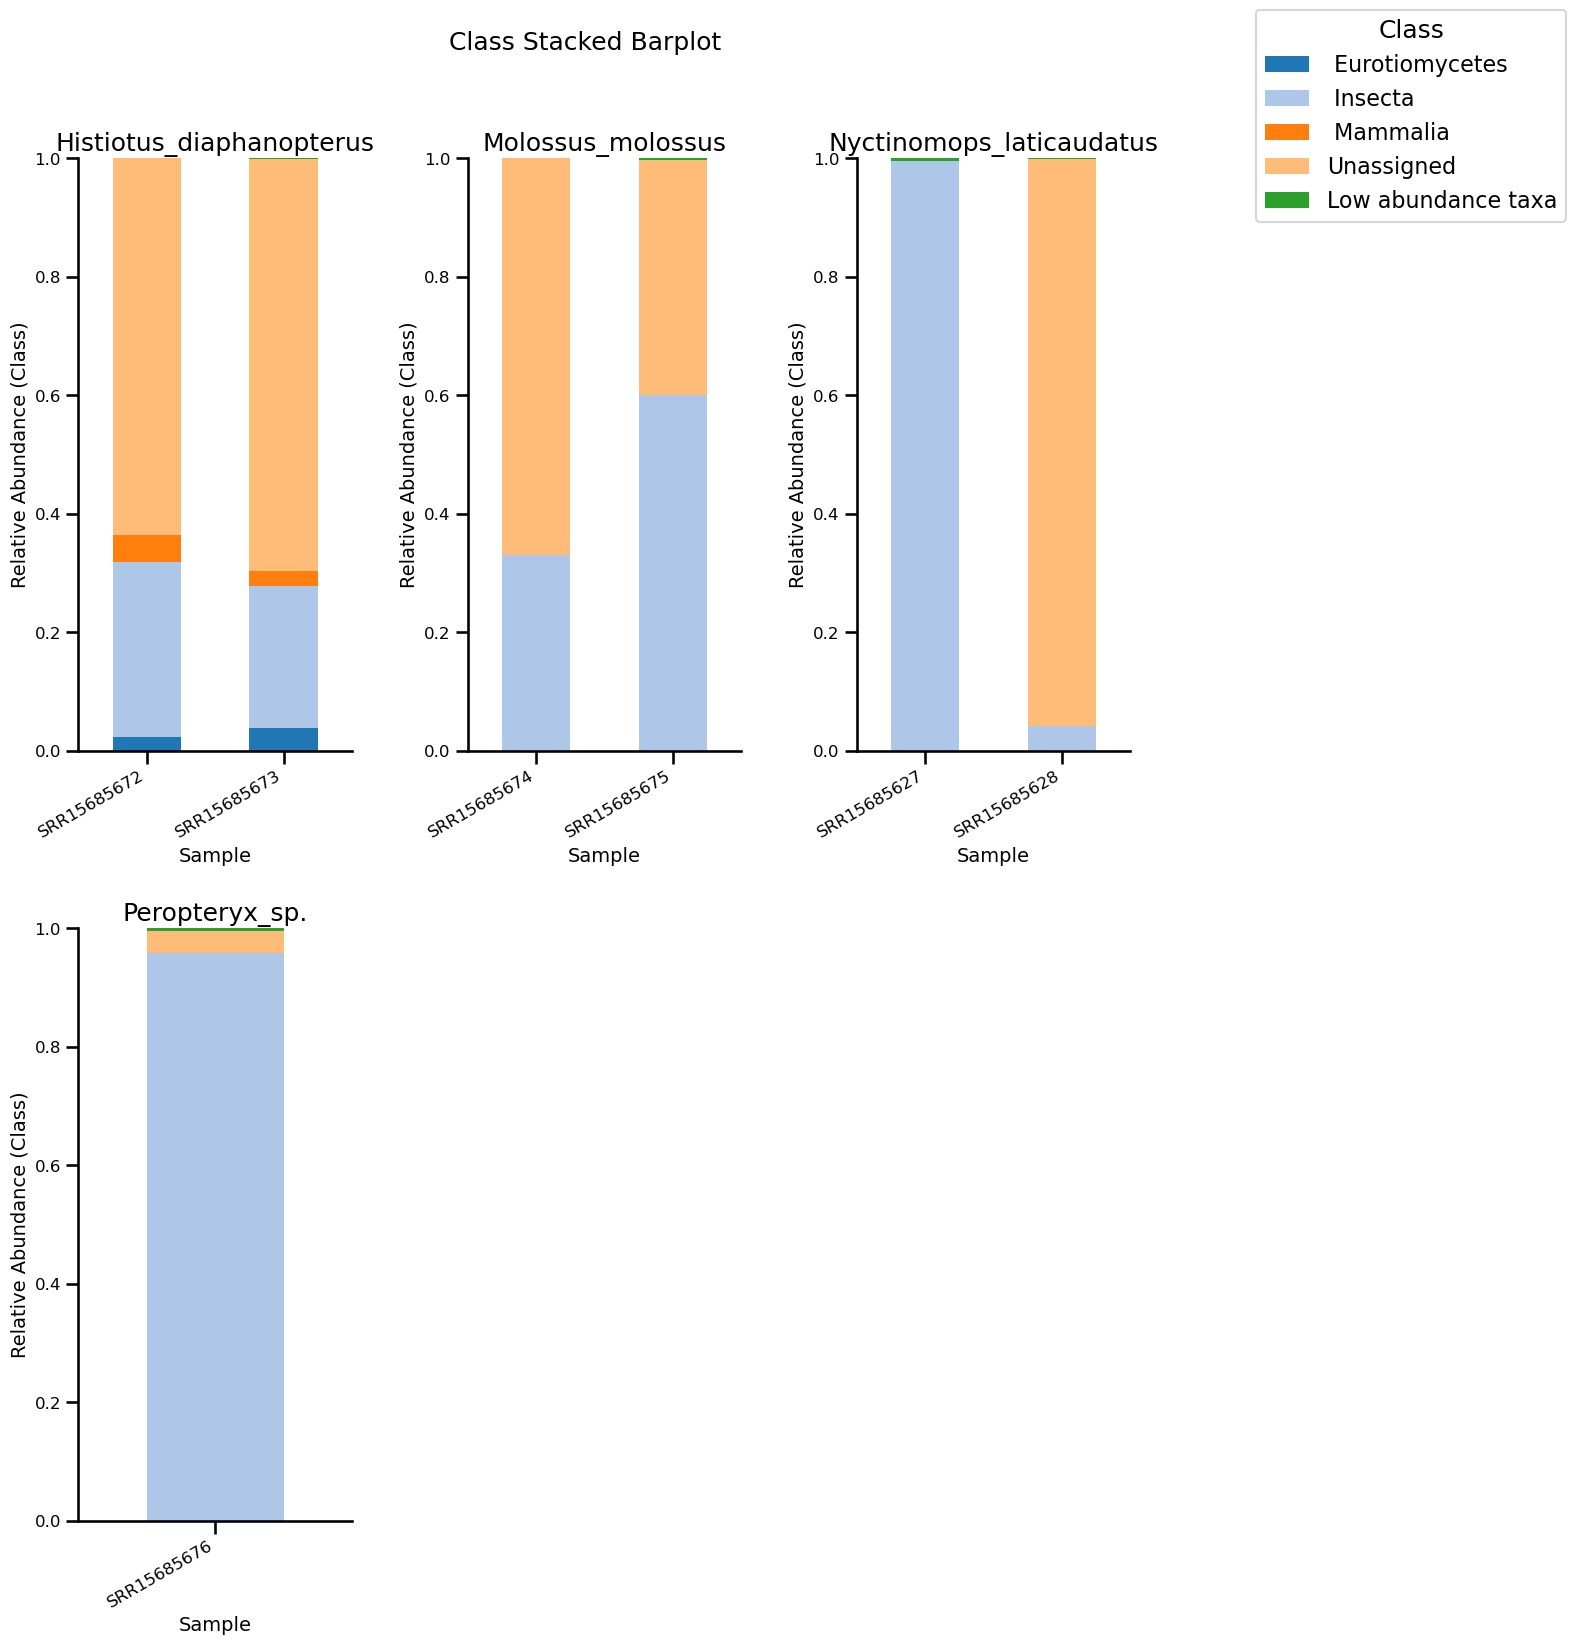

In [8]:
plot_taxonomic_composition(otu_table_df, tax_table_df, meta_table_df, 'class', output_dir, 'Species')

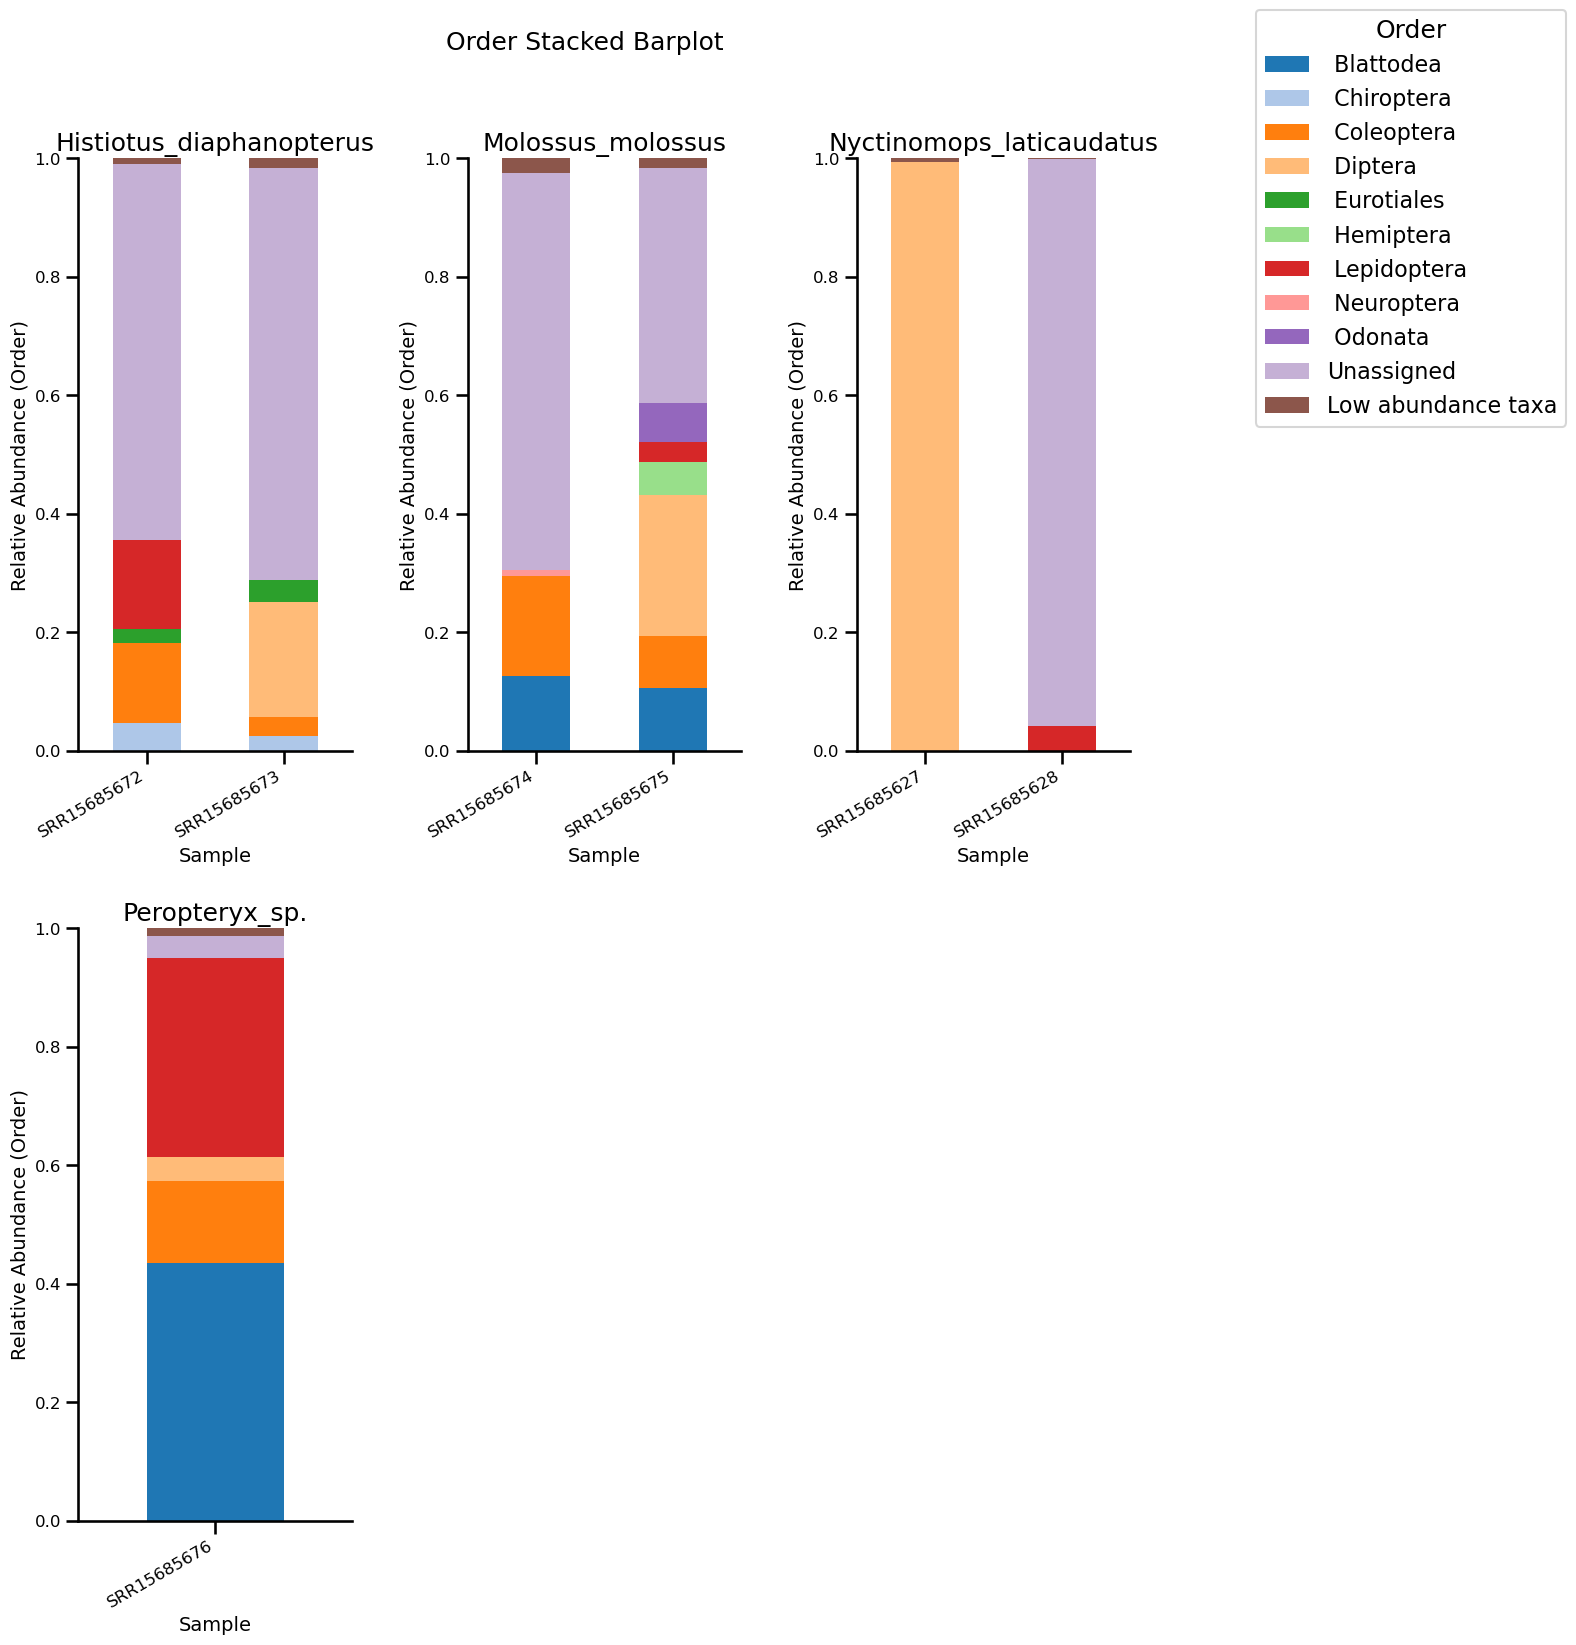

In [9]:
plot_taxonomic_composition(otu_table_df, tax_table_df, meta_table_df, 'order', output_dir, 'Species')

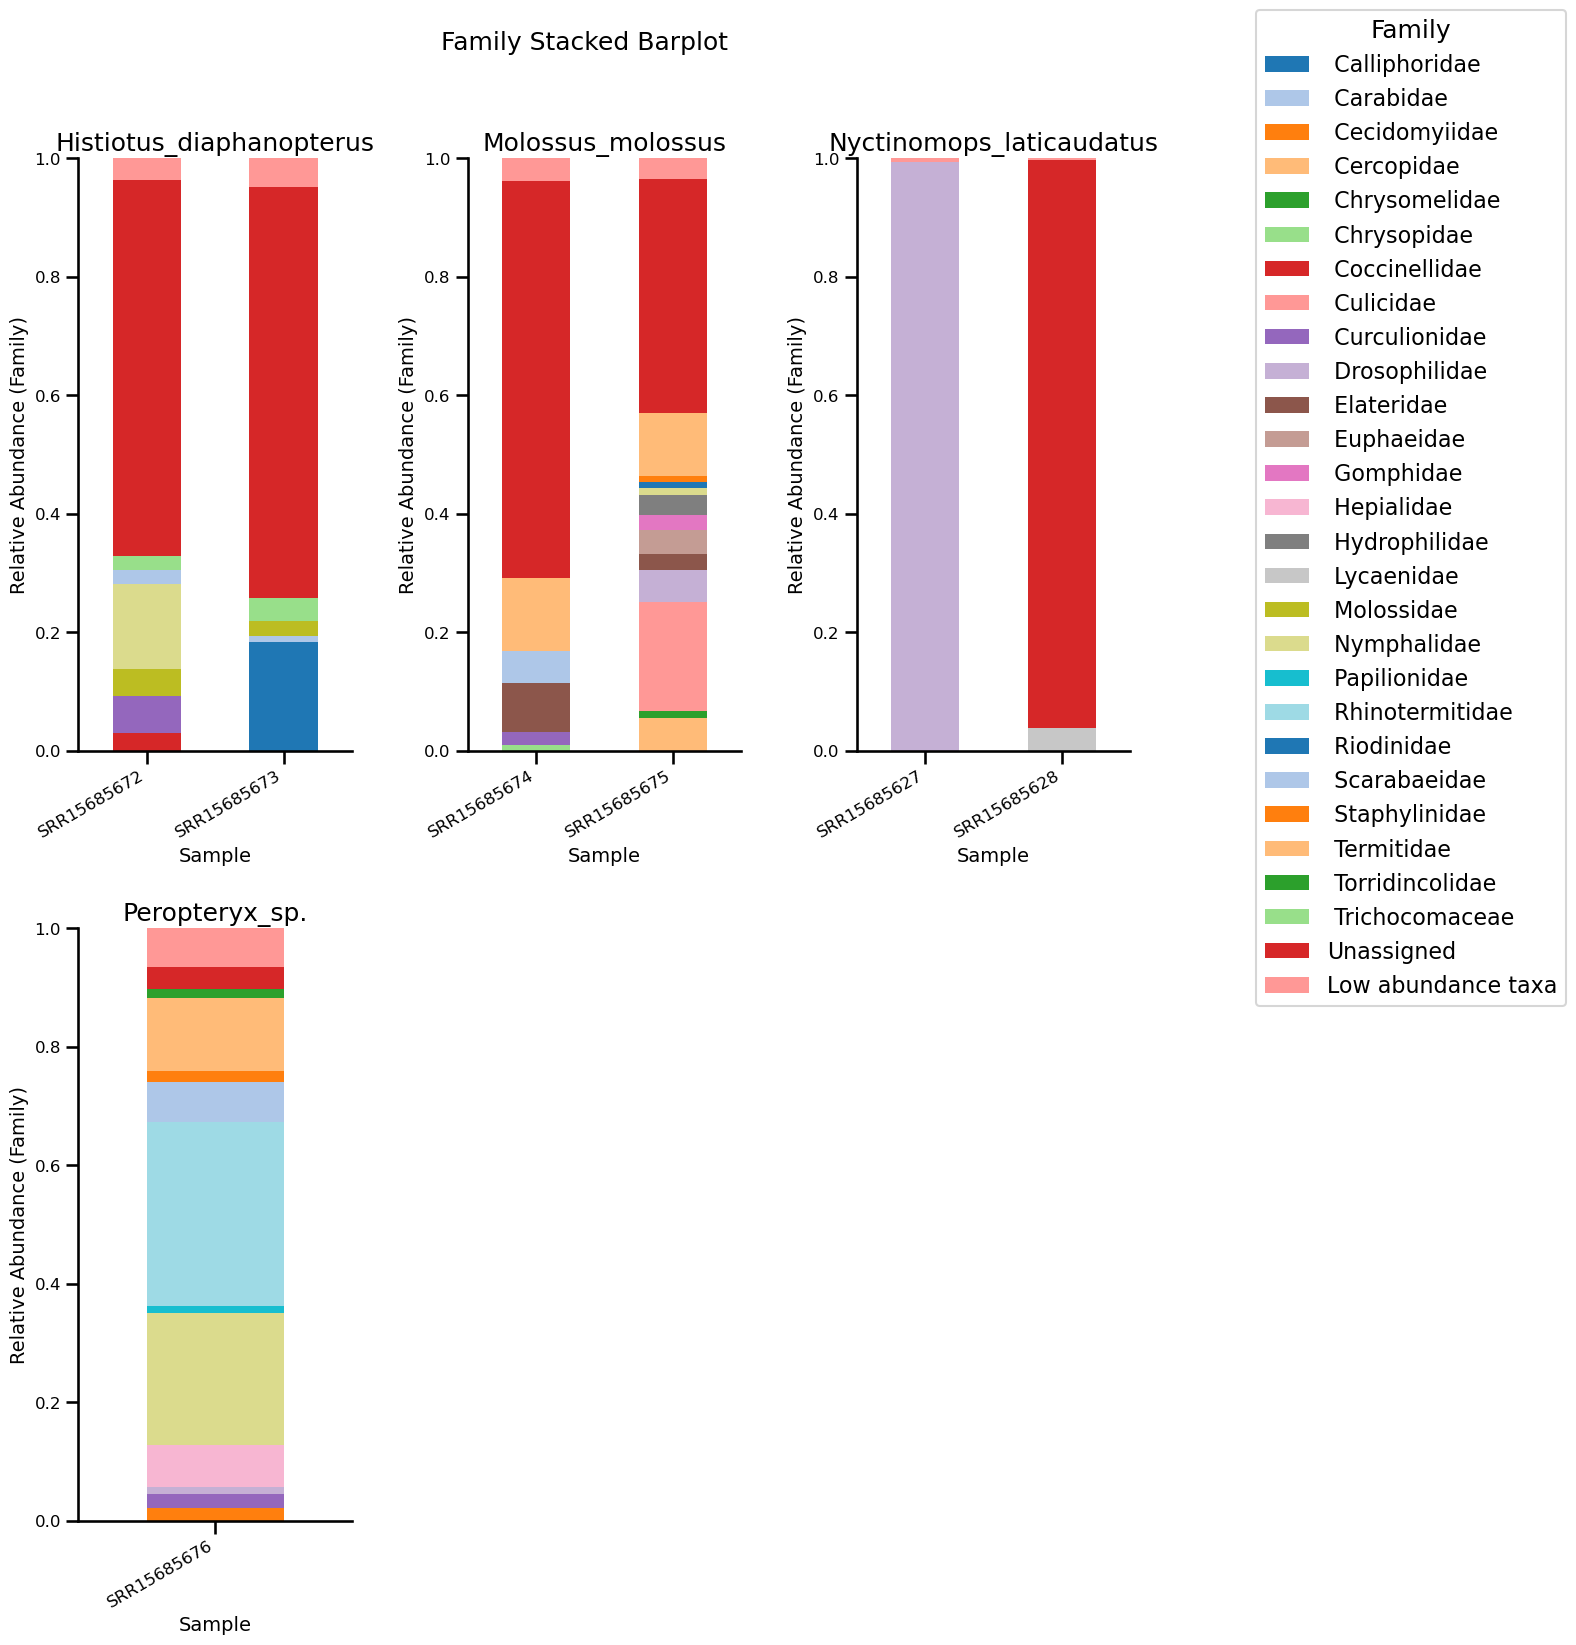

In [10]:
plot_taxonomic_composition(otu_table_df, tax_table_df, meta_table_df, 'family', output_dir, 'Species')

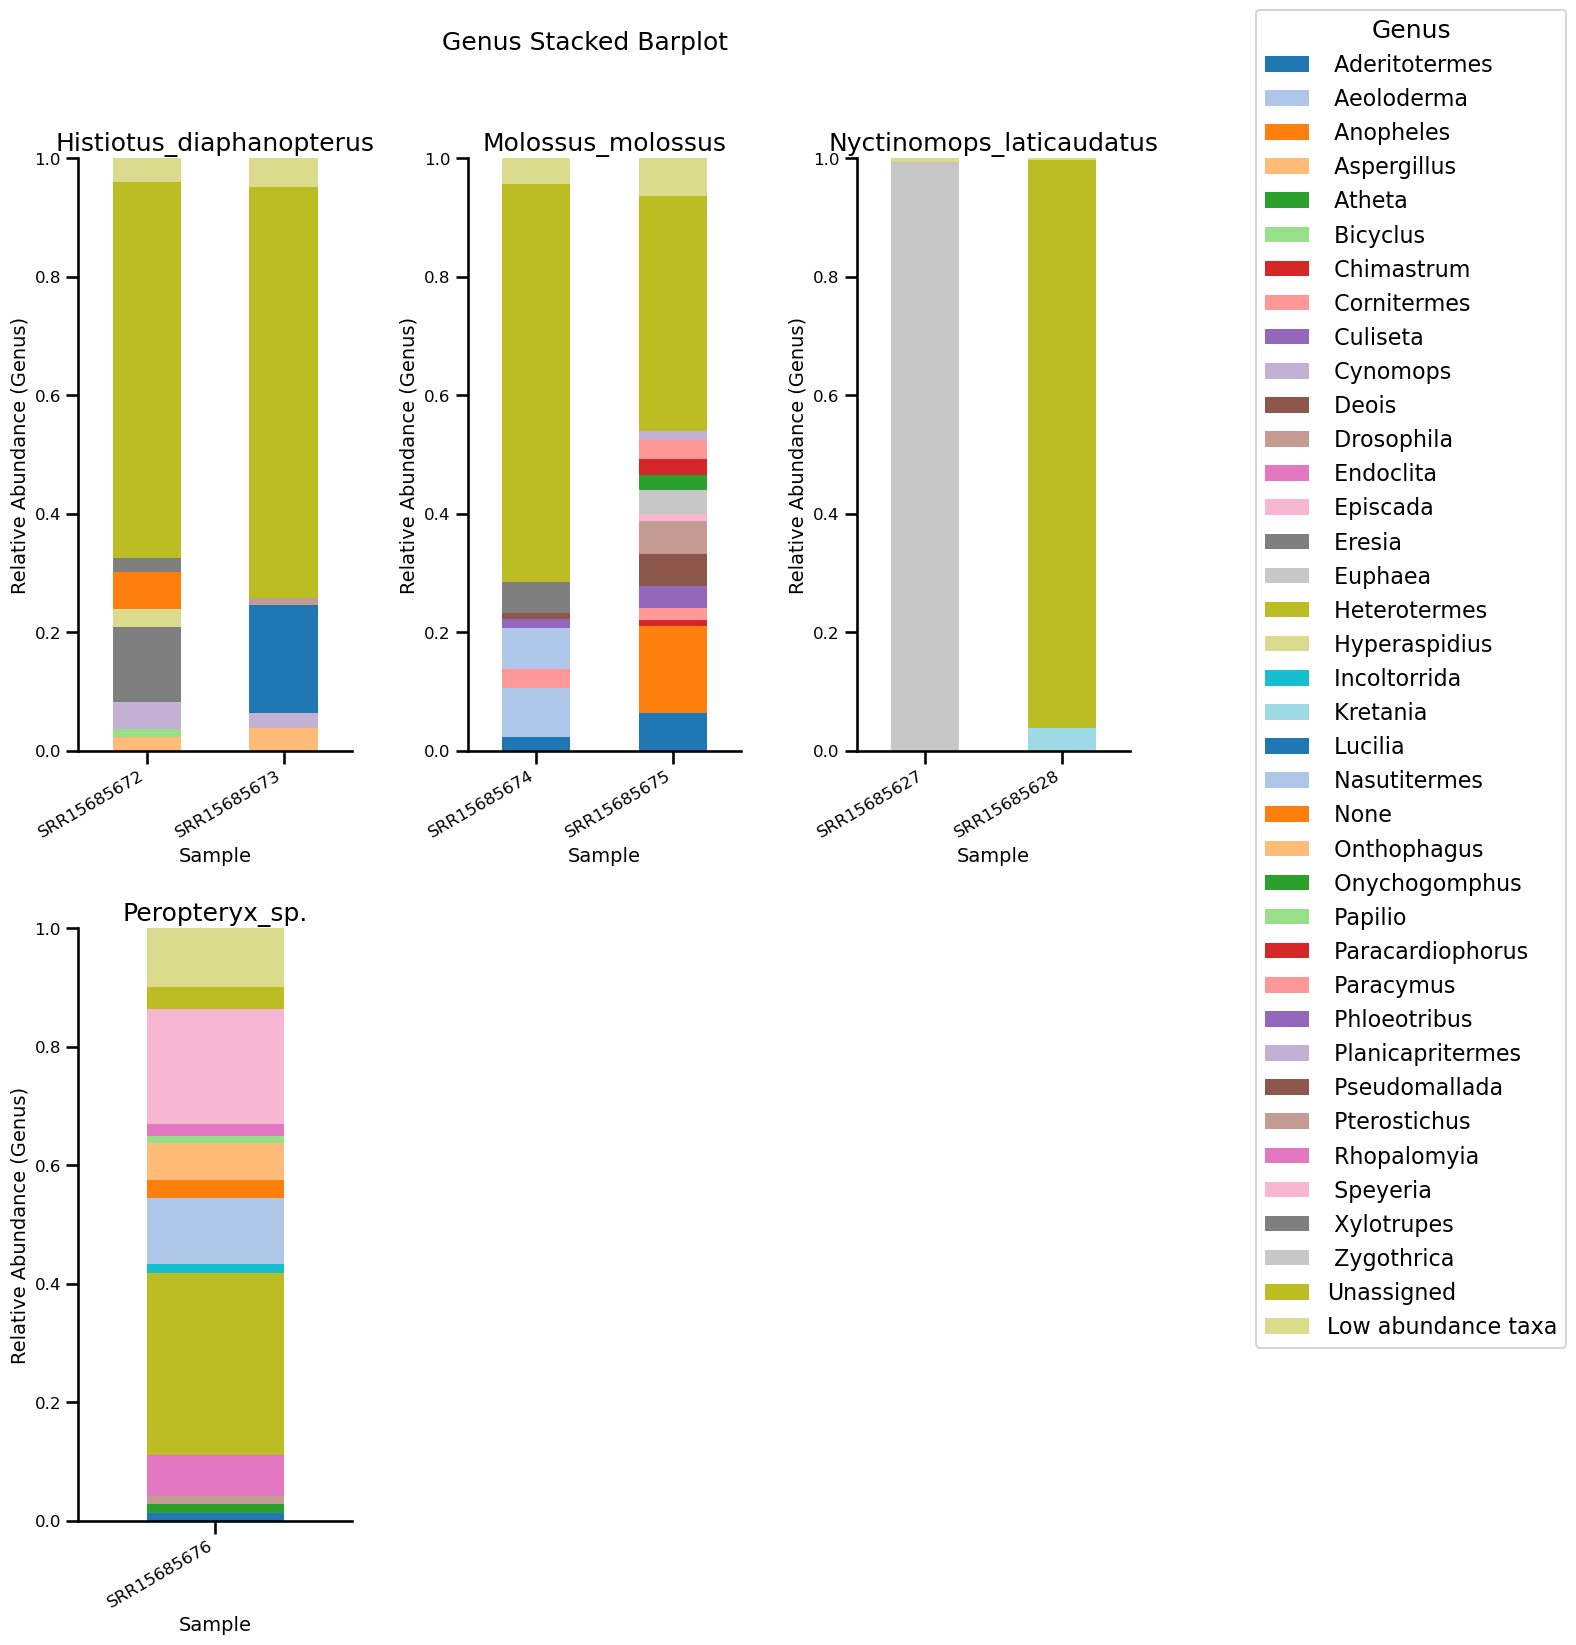

In [11]:
plot_taxonomic_composition(otu_table_df, tax_table_df, meta_table_df, 'genus', output_dir, 'Species')

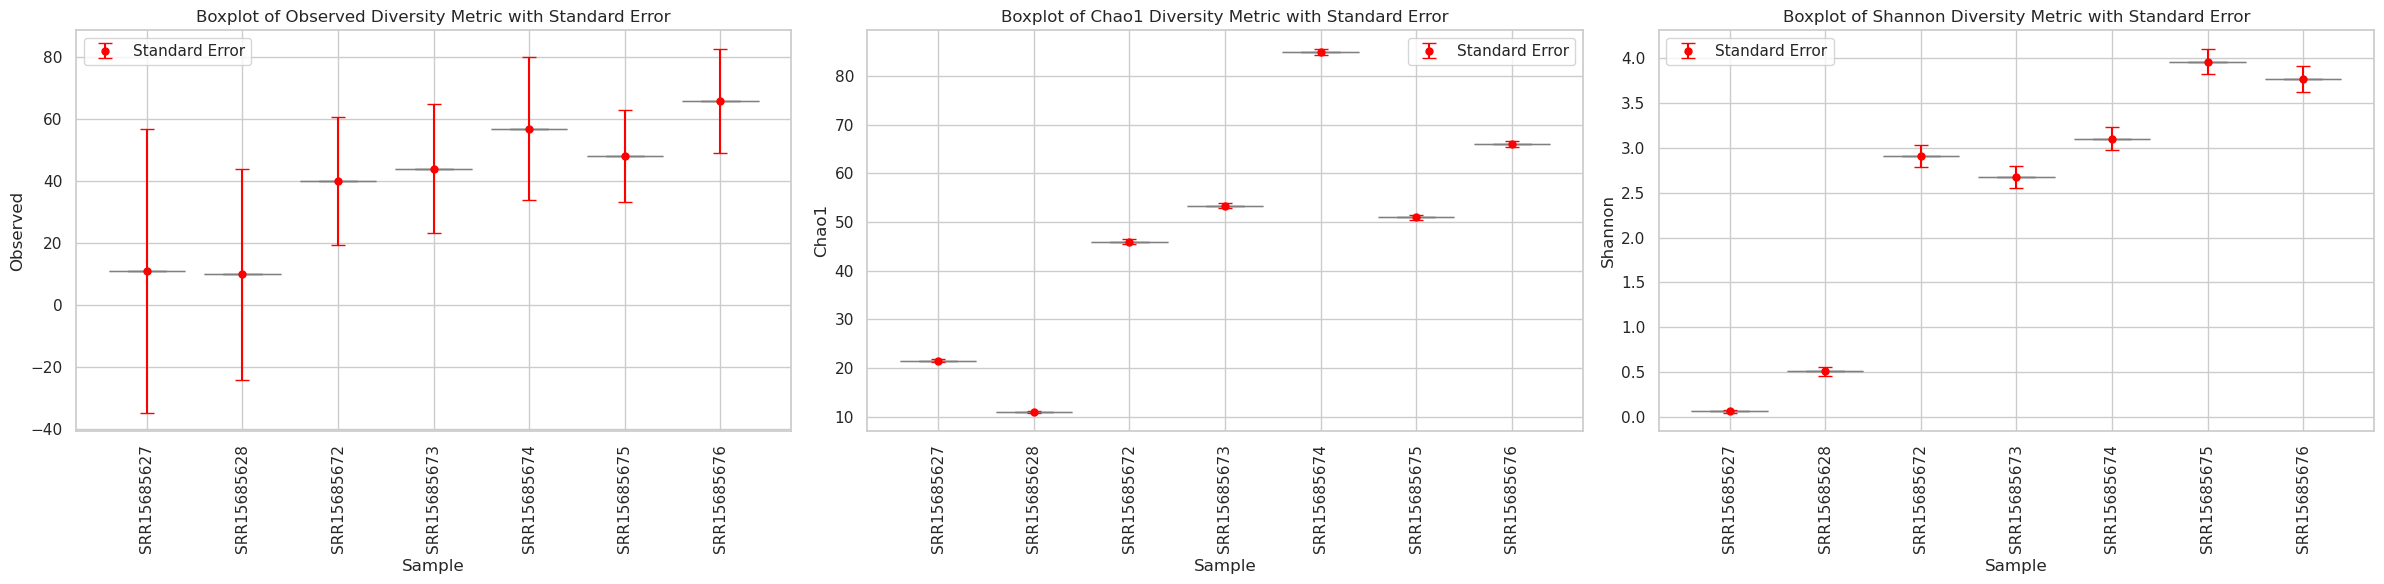

In [12]:
def plot_alpha_diversity(otu_table_df, output_dir):
    def calculate_alpha_diversity(otu_table):
        # Calculate observed species
        observed = otu_table.apply(lambda x: x[x > 0].count(), axis=0)
        observed_se = otu_table.apply(lambda x: x.std() / np.sqrt(len(x)), axis=0)

        # Calculate Chao1
        chao1 = otu_table.apply(lambda x: skbio.diversity.alpha.chao1(x), axis=0)
        chao1_se = np.sqrt((chao1 * (1 / len(otu_table))))  # Adjust standard error calculation

        # Calculate Shannon index
        shannon = otu_table.apply(lambda x: skbio.diversity.alpha.shannon(x), axis=0)
        shannon_se = np.sqrt((shannon * (1 / len(otu_table))))  # Adjust standard error calculation

        return (observed, observed_se), (chao1, chao1_se), (shannon, shannon_se)

    # Calculate the alpha diversity measures and their standard errors
    (observed, observed_se), (chao1, chao1_se), (shannon, shannon_se) = calculate_alpha_diversity(otu_table_df)

    # Create a DataFrame for plotting
    alpha_diversity_df = pd.DataFrame({
        'Sample': otu_table_df.columns,  # Using the sample names from the columns
        'Observed': observed,
        'Observed_se': observed_se,
        'Chao1': chao1,
        'Chao1_se': chao1_se,
        'Shannon': shannon,
        'Shannon_se': shannon_se,
    })

    # Set the aesthetics for the plots
    sns.set(style='whitegrid')

    # Create a figure with three subplots
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24, 6))

    # Create a boxplot for each alpha diversity metric with standard error bars
    metrics = ['Observed', 'Chao1', 'Shannon']
    for i, metric in enumerate(metrics):
        ax = axes[i]
        sns.boxplot(data=alpha_diversity_df, x='Sample', y=metric, color='lightgray', boxprops=dict(alpha=.5), ax=ax)
        
        # Overlay the standard error bars
        ax.errorbar(x=np.arange(len(alpha_diversity_df['Sample'].unique())), 
                    y=alpha_diversity_df.groupby('Sample')[metric].mean(),
                    yerr=alpha_diversity_df.groupby('Sample')[f'{metric}_se'].mean(),
                    fmt='o', color='red', capsize=5, label='Standard Error', markersize=5)
        
        ax.set_title(f'Boxplot of {metric} Diversity Metric with Standard Error')
        ax.set_ylabel(metric)
        ax.grid(True)
        ax.legend()
        # Set the ticks and rotate x-axis labels
        ax.set_xticks(np.arange(len(alpha_diversity_df['Sample'].unique())))
        ax.set_xticklabels(alpha_diversity_df['Sample'].unique(), rotation=90)

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Save the figure to a file
    plt.savefig(os.path.join(output_dir, 'alpha_diversity_dotplot.svg'))

# Example usage
plot_alpha_diversity(otu_table_df, output_dir)

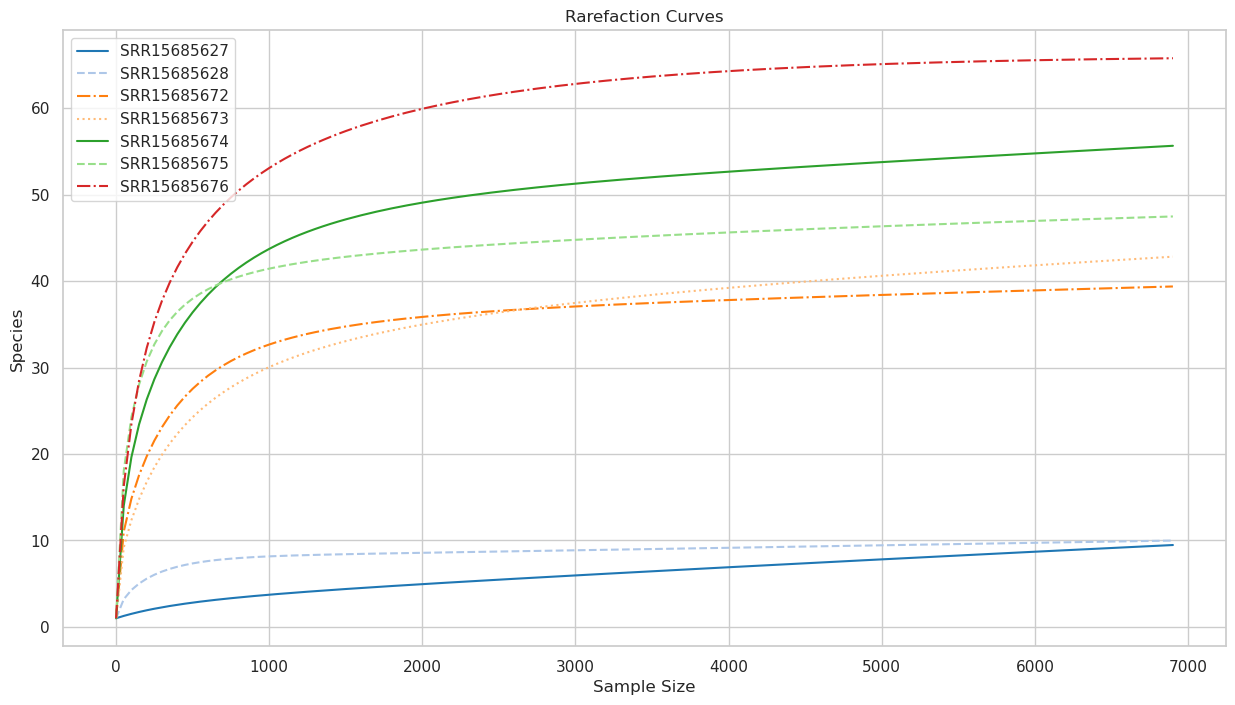

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gammaln
import os

def plot_rarefaction_curves(otu_table_df, output_dir):
    # Transpose the OTU table
    otu_dataFC = otu_table_df.T
    otu_dataFC = otu_dataFC.loc[otu_dataFC.sum(axis=1) >= 100]

    # Calculate the minimum row sum (raremax)
    raremax = otu_dataFC.sum(axis=1).min()

    # Define the rarefy function
    def rarefy(x, sample):
        x = x[x > 0]
        n = x.sum()
        if sample > n:
            print(f"Warning: specified 'sample' size is larger than the observed number of individuals in one or more sites")
            sample = n
        p = sample / n
        log_comb = lambda n, k: gammaln(n + 1) - gammaln(k + 1) - gammaln(n - k + 1)
        rare = sum(1 - np.exp(log_comb(n - x, sample) - log_comb(n, sample)))
        return rare

    # Plotting parameters
    lty = ['-', '--', '-.', ':']
    palette = plt.cm.tab20.colors

    # Generate the parameter grid
    pars = [{'col': palette[i % len(palette)], 'lty': lty[i % len(lty)]} for i in range(len(otu_dataFC))]

    # Create the plot
    plt.figure(figsize=(15, 8))
    for i, (idx, row) in enumerate(otu_dataFC.iterrows()):
        col = pars[i]['col']
        linestyle = pars[i]['lty']
        rare_curve = [rarefy(row, n) for n in range(1, int(raremax) + 1, 50)]
        plt.plot(range(1, int(raremax) + 1, 50), rare_curve, label=idx, color=col, linestyle=linestyle)

    # Adding labels and legend
    plt.xlabel('Sample Size')
    plt.ylabel('Species')
    plt.title('Rarefaction Curves')
    plt.legend(loc='best')

    # Save the plot as an SVG file
    plt.savefig(os.path.join(output_dir, 'rarefaction_curve2.svg'))

# Example usage
plot_rarefaction_curves(otu_table_df, output_dir)

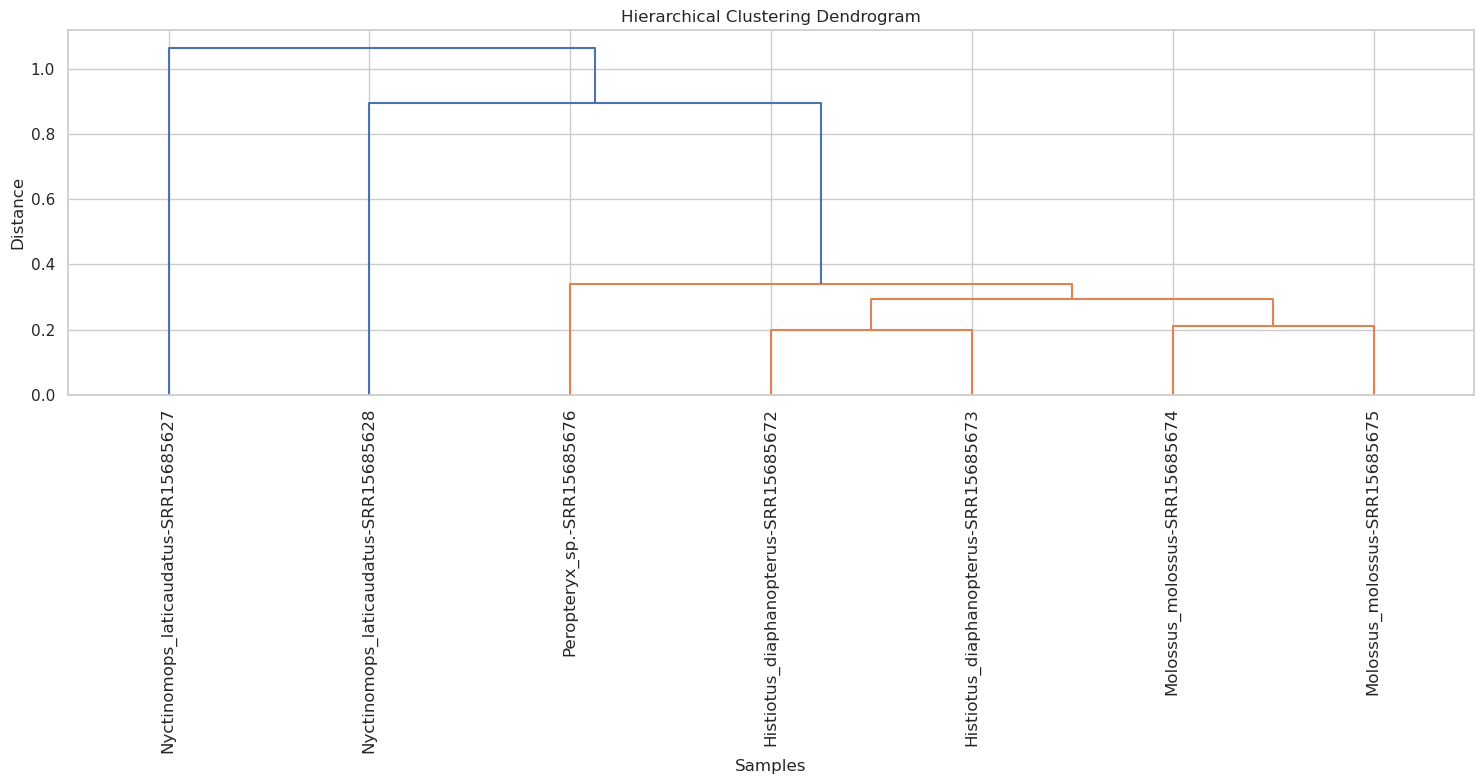

In [14]:
def plot_cluster_dendrogram(otu_table_df, meta_table_df, output_dir, groupby):
    # Transpose OTU table to have samples as rows
    otu_data = otu_table_df.T

    # Function to calculate Bray-Curtis distance
    def bray_curtis_distance(otu_table):
        """Calculate the Bray-Curtis distance matrix."""
        otu_df = pd.DataFrame(otu_table)
        # Calculate the total for each row and create a normalized DataFrame
        row_sums = otu_df.sum(axis=1)
        normalized_df = otu_df.div(row_sums, axis=0)  # Normalize by row sums
        # Calculate the Bray-Curtis distance matrix
        return 1 - normalized_df.dot(normalized_df.T)

    # Compute the distance matrix
    distance_matrix = bray_curtis_distance(otu_data)

    # Hierarchical clustering using average linkage
    linked = linkage(distance_matrix, method='average')

    # Reorder samples and append group information if groupby is specified
    if groupby and groupby in meta_table_df.columns:
        order = dendrogram(linked, no_plot=True)['leaves']
        reordered_samples = [otu_table_df.columns[i] for i in order]
        reordered_groups = meta_table_df.loc[reordered_samples, groupby]
        labels = [f"{group}-{sample}" for group, sample in zip(reordered_groups, reordered_samples)]
    else:
        labels = otu_table_df.columns

    # Plotting the dendrogram with new labels
    plt.figure(figsize=(15, 8))
    dendrogram(linked, labels=labels, orientation='top')
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Samples')
    plt.xticks(rotation=90)
    plt.ylabel('Distance')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "cluster_dendrogram.svg"))

# Example usage
plot_cluster_dendrogram(otu_table_df, meta_table_df, output_dir, 'Species')

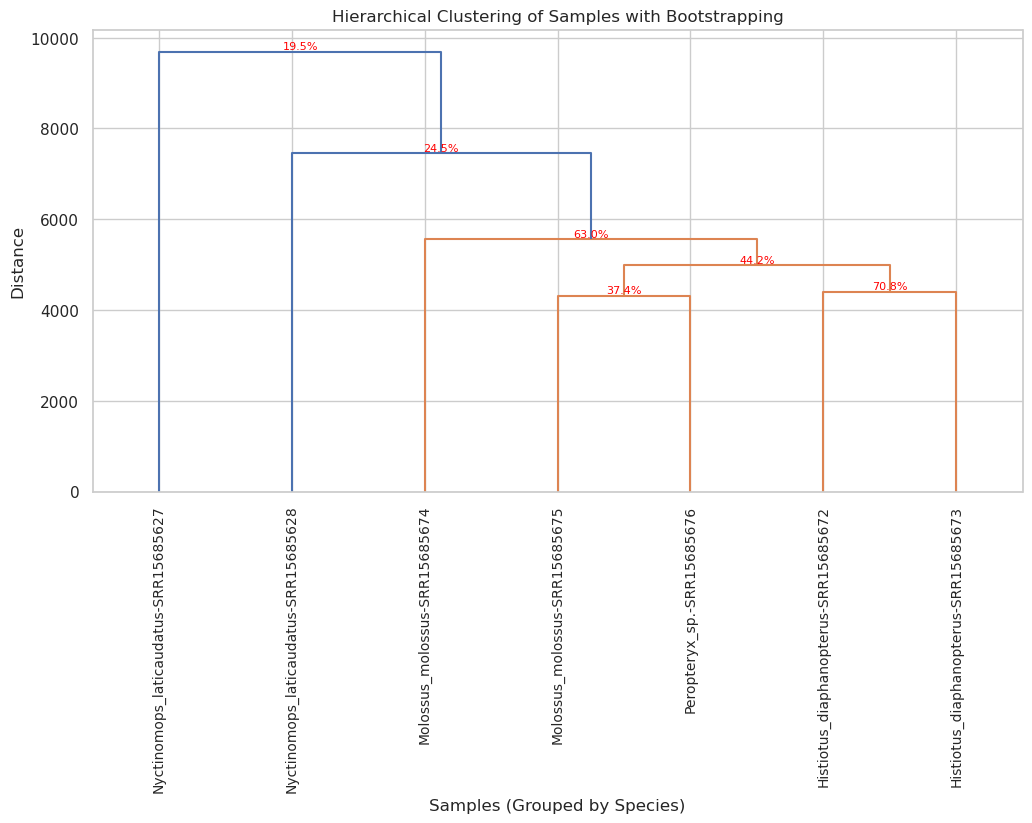

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist

def hierarchical_clustering_with_bootstrap(otu_table_df, meta_table_df, output_dir, groupby, n_bootstrap):
    # Load metadata if groupby is specified
    if groupby:
        # Append metadata group names to sample labels
        sample_labels = []
        for sample in otu_table_df.columns:
            if sample in meta_table_df.index:
                sample_labels.append(f"{meta_table_df.loc[sample, groupby]}-{sample}")
            else:
                sample_labels.append(sample)  # Keep original name if not found in metadata
    else:
        sample_labels = list(otu_table_df.columns)  # Keep original sample names

    # Transpose to cluster **samples**
    data = otu_table_df.T.astype(float)

    # Perform hierarchical clustering on original data
    original_linkage = linkage(pdist(data, metric='euclidean'), method='average')

    # Bootstrap parameters
    n_otus = data.shape[1]
    n_samples = data.shape[0]

    # Track cluster co-occurrence
    co_occurrence = np.zeros((n_samples, n_samples))

    # Bootstrap resampling
    for _ in range(n_bootstrap):
        resampled_idx = np.random.choice(range(n_otus), size=n_otus, replace=True)  # Resample OTUs
        resampled_data = data.iloc[:, resampled_idx]

        resampled_linkage = linkage(pdist(resampled_data, metric='euclidean'), method='average')
        clusters = fcluster(resampled_linkage, t=0.5 * max(resampled_linkage[:, 2]), criterion='distance')

        for i in range(n_samples):
            for j in range(i + 1, n_samples):
                if clusters[i] == clusters[j]:  # If samples cluster together
                    co_occurrence[i, j] += 1
                    co_occurrence[j, i] += 1  # Symmetric matrix

    # Normalize bootstrap values
    co_occurrence = (co_occurrence / n_bootstrap) * 100

    # Plot the dendrogram
    plt.figure(figsize=(12, 6))
    dendro = dendrogram(original_linkage, labels=sample_labels, leaf_rotation=90, leaf_font_size=10)

    # Add bootstrap values at branching points
    for i, d in zip(dendro['icoord'], dendro['dcoord']):
        x = 0.5 * sum(i[1:3])  # X-coordinate for text
        y = d[1]  # Y-coordinate for text

        # Identify samples in this branch
        members = [sample_labels[int(i[1] / 10)], sample_labels[int(i[2] / 10)]]
        support = co_occurrence[sample_labels.index(members[0]), sample_labels.index(members[1])]

        plt.text(x, y, f"{support:.1f}%", va='bottom', ha='center', fontsize=8, color='red')

    plt.title('Hierarchical Clustering of Samples with Bootstrapping')
    plt.xlabel('Samples' if not groupby else f'Samples (Grouped by {groupby})')
    plt.ylabel('Distance')

    # Save the figure
    plt.savefig(os.path.join(output_dir, "cluster_bootstrap1000.svg"))

hierarchical_clustering_with_bootstrap(otu_table_df, meta_table_df, output_dir, "Species", 1000)

/home/tfleaobr/anaconda3/envs/notebook_env/lib/python3.8/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.06942260217738558 and the largest is 0.9499413389976065.
  warn(


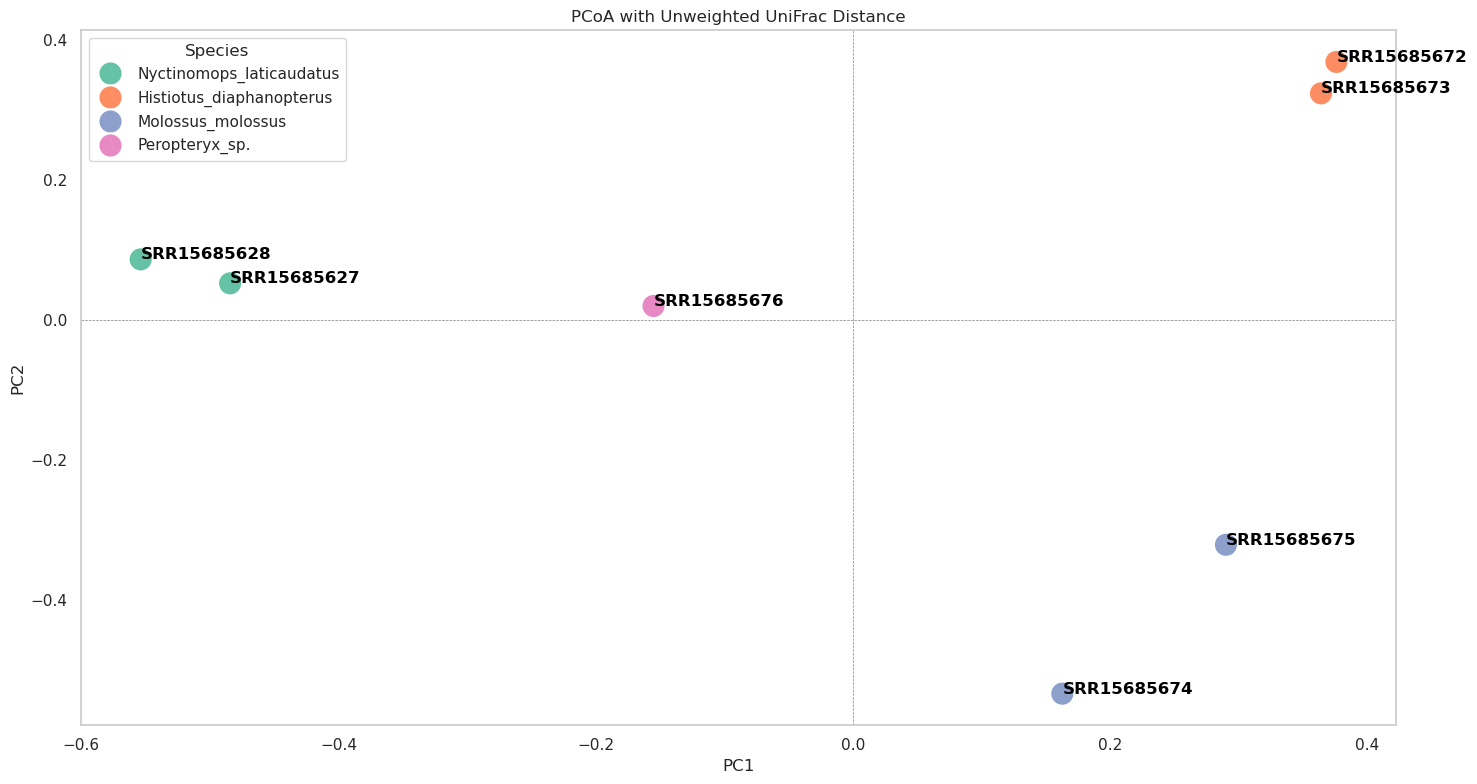

In [16]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skbio import DistanceMatrix
from skbio.tree import TreeNode
from skbio.stats.ordination import pcoa

def perform_pcoa_unweighted_unifrac(otu_table_df, meta_table_df, output_dir, groupby):
    # Function to create a random tree using a simple balanced tree approach
    def create_random_tree(tips):
        tree_str = "(" + ",".join(tips) + ");"  # Simple star-like tree
        tree = TreeNode.read([tree_str])
        return tree

    # Create a random tree using OTU names
    random_tree = create_random_tree(otu_table_df.index.tolist())

    # Function to calculate unweighted UniFrac distance manually
    def calculate_unweighted_unifrac(otu_table, tree):
        # Normalize the OTU table
        otu_table_normalized = otu_table.div(otu_table.sum(axis=0), axis=1)

        # Prepare the UniFrac distance matrix
        n_samples = otu_table_normalized.shape[1]
        unifrac_dist_matrix = np.zeros((n_samples, n_samples))

        for i in range(n_samples):
            for j in range(i + 1, n_samples):
                # Find the shared and unique OTUs
                otu_i = otu_table_normalized.iloc[:, i]
                otu_j = otu_table_normalized.iloc[:, j]
                shared_otus = (otu_i > 0) & (otu_j > 0)

                # Calculate the UniFrac distance
                unique_i = otu_i[~shared_otus].sum()
                unique_j = otu_j[~shared_otus].sum()
                unifrac_dist = (unique_i + unique_j) / (otu_i.sum() + otu_j.sum())

                # Fill in the distance matrix
                unifrac_dist_matrix[i, j] = unifrac_dist
                unifrac_dist_matrix[j, i] = unifrac_dist  # Symmetric matrix

        return DistanceMatrix(unifrac_dist_matrix, otu_table.columns.tolist())

    # Calculate the distance matrix
    unifrac_dist = calculate_unweighted_unifrac(otu_table_df, random_tree)

    # Perform PCoA
    ordination_results = pcoa(unifrac_dist)

    # Create a DataFrame for the results
    pcoa_df = pd.DataFrame(ordination_results.samples, index=otu_table_df.columns.tolist())
    pcoa_df['SampleName'] = otu_table_df.columns.tolist()  # Add sample names for labeling

    # Add group information if groupby is specified
    if groupby and groupby in meta_table_df.columns:
        pcoa_df[groupby] = meta_table_df.loc[pcoa_df['SampleName'], groupby]

    # Plotting the PCoA results
    plt.figure(figsize=(15, 8))
    sns.scatterplot(data=pcoa_df, x='PC1', y='PC2', hue=groupby if groupby and groupby in pcoa_df.columns else None, palette='Set2', s=300)

    # Annotate each point with the sample name
    for i, sample_name in enumerate(pcoa_df['SampleName']):
        plt.text(pcoa_df['PC1'].iloc[i], pcoa_df['PC2'].iloc[i], sample_name,
                 horizontalalignment='left', size='medium', color='black', weight='semibold')

    plt.title('PCoA with Unweighted UniFrac Distance')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.axhline(0, color='grey', lw=0.5, ls='--')
    plt.axvline(0, color='grey', lw=0.5, ls='--')
    plt.grid()
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "PCoA_unweighted_unifrac.svg"))

# Example usage
perform_pcoa_unweighted_unifrac(otu_table_df, meta_table_df, output_dir, 'Species')

/home/tfleaobr/anaconda3/envs/notebook_env/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


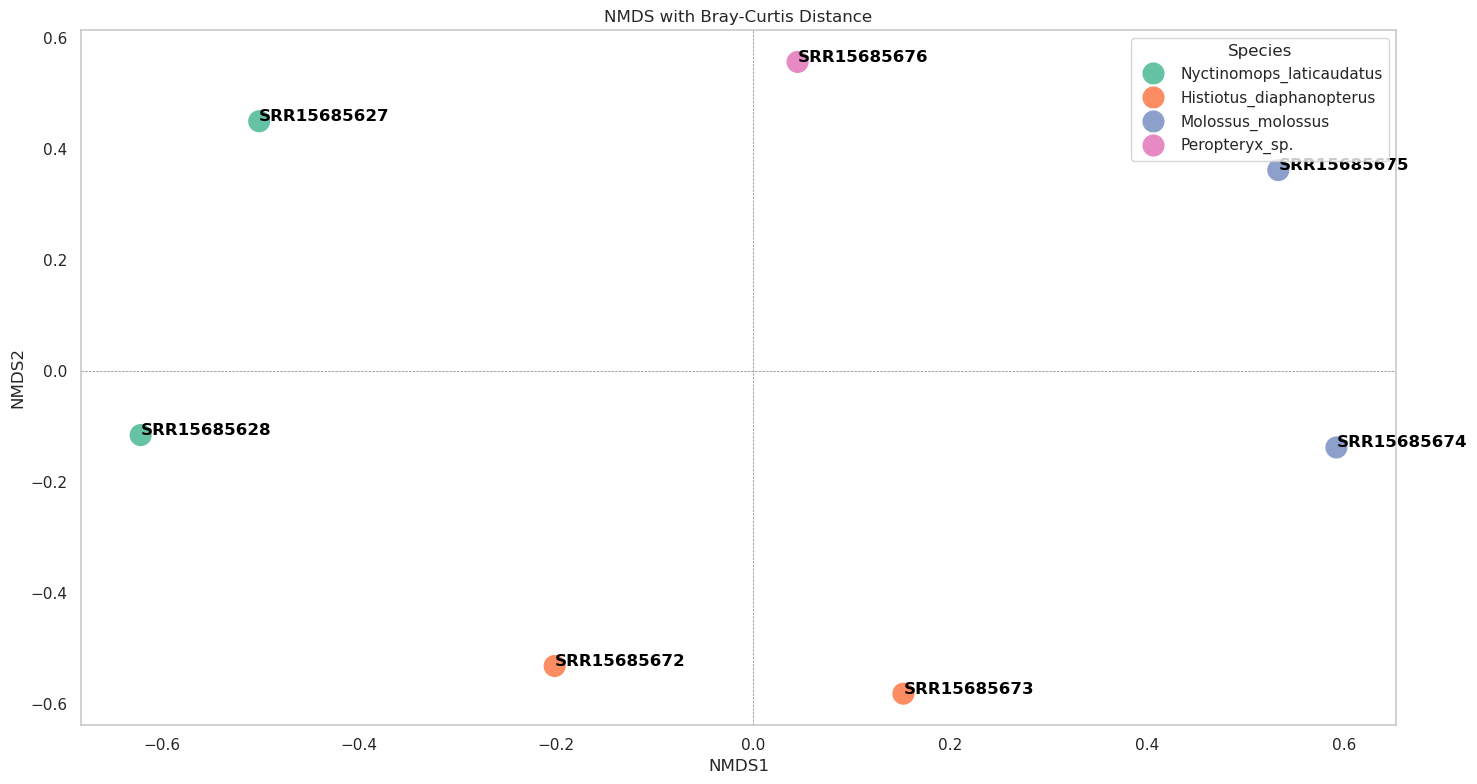

In [17]:
def perform_nmds_bray_curtis(otu_table_df, meta_table_df, output_dir, groupby):
    # Function to calculate Bray-Curtis distance
    def calculate_bray_curtis(otu_table):
        # Normalize the OTU table
        otu_table_normalized = otu_table.div(otu_table.sum(axis=0), axis=1)

        # Create a distance matrix
        n_samples = otu_table_normalized.shape[1]
        bray_curtis_matrix = np.zeros((n_samples, n_samples))

        for i in range(n_samples):
            for j in range(n_samples):
                # Calculate Bray-Curtis distance
                if i != j:
                    bray_curtis_dist = (otu_table_normalized.iloc[:, i] - otu_table_normalized.iloc[:, j]).abs().sum() / (otu_table_normalized.iloc[:, i] + otu_table_normalized.iloc[:, j]).sum()
                    bray_curtis_matrix[i, j] = bray_curtis_dist
                else:
                    bray_curtis_matrix[i, j] = 0.0  # Distance to itself is zero

        return DistanceMatrix(bray_curtis_matrix, otu_table.columns.tolist())

    # Calculate the distance matrix
    bray_curtis_dist = calculate_bray_curtis(otu_table_df)

    # Perform NMDS using scikit-learn
    nmds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
    nmds_results = nmds.fit_transform(bray_curtis_dist.data)

    # Create a DataFrame for the results
    nmds_df = pd.DataFrame(nmds_results, index=otu_table_df.columns.tolist(), columns=['NMDS1', 'NMDS2'])
    nmds_df['SampleName'] = otu_table_df.columns.tolist()  # Add sample names for labeling

    # Add group information if groupby is specified
    if groupby and groupby in meta_table_df.columns:
        nmds_df[groupby] = meta_table_df.loc[nmds_df['SampleName'], groupby]

    # Plotting the NMDS results
    plt.figure(figsize=(15, 8))
    sns.scatterplot(data=nmds_df, x='NMDS1', y='NMDS2', hue=groupby if groupby and groupby in nmds_df.columns else None, palette='Set2', s=300)

    # Annotate each point with the sample name
    for i, sample_name in enumerate(nmds_df['SampleName']):
        plt.text(nmds_df['NMDS1'].iloc[i], nmds_df['NMDS2'].iloc[i], sample_name,
                 horizontalalignment='left', size='medium', color='black', weight='semibold')

    # Title and labels
    plt.title('NMDS with Bray-Curtis Distance')
    plt.xlabel('NMDS1')
    plt.ylabel('NMDS2')
    plt.axhline(0, color='grey', lw=0.5, ls='--')
    plt.axvline(0, color='grey', lw=0.5, ls='--')
    plt.grid()
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "NMDS_bray.svg"))

# Example usage
perform_nmds_bray_curtis(otu_table_df, meta_table_df, output_dir, 'Species')

'jupyter nbconvert --to html pimba_plot_python.ipynb'